In [63]:
import numpy as np
import pandas as pd
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import glob
from astropy.table import Table 
from spectres import spectres

In [64]:
data = Table.read('/data/praveen/emission_candidates_klemen/results_emission_lines_final_mnras.fits', format='fits')

In [65]:
df_all = data.to_pandas()

In [66]:
df_all.head()

,source_id,sobject_id,ra,dec,Ha_EW,Hb_EW,Ha_EW_abs,Hb_EW_abs,Ha_W10,Ha_EW_asym,...,SB2_c1,NII,SII,NII_EW,SII_EW,rv_NII,rv_SII,nebular,emiss,flag
0,4667368899326729856,131116000501002,53.219667,-68.675139,-0.041336,-0.128504,0.110269,0.346573,21.851629,0.018468,...,False,0,0,0.000000,0.007487,-42.985878,-52.369164,False,False,0
1,4667362989451832448,131116000501003,53.724417,-68.610056,-0.093059,-0.032066,0.136851,0.350298,12.018717,0.146598,...,False,0,0,-0.010351,0.000000,-69.839996,-75.075890,False,False,0
2,4667324643983679744,131116000501004,55.594000,-68.697833,-0.004435,0.244539,0.124381,0.360633,42.366215,-0.171434,...,False,0,0,0.013567,0.000000,-95.912048,-100.068390,False,False,0
3,4667335913977929728,131116000501005,54.392042,-68.685056,-0.063868,-0.121597,0.086837,0.173505,32.563042,0.277683,...,False,0,0,0.000000,-0.000524,38.587879,53.383396,False,False,0
4,4667323681911007232,131116000501006,55.770375,-68.722472,0.045687,-0.133048,0.112489,0.197745,16.599590,-0.051486,...,False,0,0,0.000000,0.012277,-10.203407,-128.818909,False,False,0


In [68]:
df_all.emiss.value_counts()

False    648555
True      10364
Name: emiss, dtype: int64

In [73]:
df_emiss = df_all.loc[df_all['Ha_EW'] > 2.99]

In [74]:
df_emiss.head()

,source_id,sobject_id,ra,dec,Ha_EW,Hb_EW,Ha_EW_abs,Hb_EW_abs,Ha_W10,Ha_EW_asym,...,SB2_c1,NII,SII,NII_EW,SII_EW,rv_NII,rv_SII,nebular,emiss,flag
24151,5820283738165246592,140312004501116,233.681542,-68.667944,3.446387,1.102516,3.446387,1.102516,380.576050,-0.078876,...,False,0,0,-0.016009,0.115730,55.832729,78.121681,False,True,0
47296,6243142063220661504,140610004401018,240.535208,-22.916361,3.868500,2.251874,3.868500,2.422946,120.969742,-0.074651,...,False,2,1,0.077251,0.089863,7.205760,15.979729,True,True,0
147815,6244153510833937920,150429003101162,242.104625,-20.206833,2.995574,2.332019,2.995842,2.445844,117.058044,-0.078187,...,False,0,0,0.006486,0.097599,41.167614,35.655373,False,True,0
147895,6245775565362814592,150429003101268,242.476750,-19.115278,3.591918,2.563747,3.591918,2.776411,133.824905,-0.083017,...,False,0,0,-0.069617,0.079971,194.283859,59.855751,False,True,0
163446,5399307021070033280,150607002101054,171.717500,-35.057528,8.136639,-0.147007,12.843852,0.338017,214.178101,-0.088345,...,False,0,0,46.800369,1.762267,626.196838,91.550674,False,False,36


In [75]:
sobject_ids = df_emiss["sobject_id"].to_numpy().tolist()

In [76]:
len(sobject_ids)

48

In [89]:
print(sobject_ids)

[140312004501116, 140610004401018, 150429003101162, 150429003101268, 150607002101054, 151227004701358, 160123002601012, 160130003601074, 160422005701151, 160522003101072, 160612002701289, 161107003901377, 170109002801312, 170408005001217, 170413003601067, 170508003301221, 170509007701008, 170603004101235, 170604002101145, 170615004901032, 170908001601014, 170908001601020, 171208002601199, 171208003101198, 171230005101052, 181222001801015, 190206003501044, 190207001801371, 190210001601238, 190210002401037, 190210002401302, 190211001601148, 190211001601192, 190211002201024, 190211002201360, 190212001601279, 190212001601319, 190212001601338, 190212001601342, 190212001601351, 190212001601391, 190212002001198, 190223001701026, 190223001701062, 190223001701241, 190224002101004, 190224002101351, 190224002101374]


Resample data 

In [77]:
GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740

In [78]:
regrid = np.arange(LOWER_LAMBDA, UPPER_LAMBDA, GRID_SIZE)

In [79]:
def read_spectra(sobject_id):
    fits_files = [[],[],[],[]]
    for each_ccd in [1,2,3,4]:
        fits_files[each_ccd-1] = glob.glob('/data/praveen/galah-total/galah/dr3/spectra/hermes/'+str(sobject_id)+str(each_ccd)+'.fits') #this is reading fits files from file and not downloading directly 

    spectrum = dict()
    for each_ccd in [1,2,3,4]: #GALAH uses indexing from 1 - 4
        if fits_files[each_ccd-1]!=[]: #just using zero indexing here 
            fits = pyfits.open(fits_files[each_ccd-1][0]) 
            
            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the reduced spectrum 

            # Extract wavelength grid for the normalised spectrum
            start_wavelength = fits[4].header["CRVAL1"]
            dispersion       = fits[4].header["CDELT1"]
            nr_pixels        = fits[4].header["NAXIS1"]
            reference_pixel  = fits[4].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel=1
            spectrum['wave_norm_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the normalised spectrum 

            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data)
            spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
            if each_ccd != 4:
                spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
            else:
                # for normalised error of CCD4, only used appropriate parts of error spectrum
                spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])

            fits.close()
        else:
            spectrum['wave_red_'+str(each_ccd)] = []
            spectrum['wave_norm_'+str(each_ccd)] = []
            spectrum['sob_red_'+str(each_ccd)] = []
            spectrum['sob_norm_'+str(each_ccd)] = []
            spectrum['uob_red_'+str(each_ccd)] = []
            spectrum['uob_norm_'+str(each_ccd)] = []
    
    spectrum['wave_red'] = np.concatenate(([spectrum['wave_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['wave_norm'] = np.concatenate(([spectrum['wave_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_red'] = np.concatenate(([spectrum['sob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_norm'] = np.concatenate(([spectrum['sob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_red'] = np.concatenate(([spectrum['uob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_norm'] = np.concatenate(([spectrum['uob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))

    return spectrum 

In [80]:
def resample_spectra(spectrum, camera, verbose):

    spec_resample, spec_errs_resample = spectres(regrid,  spectrum['wave_norm_'+str(camera)], spectrum['sob_norm_'+str(camera)], spec_errs= spectrum['uob_norm_'+str(camera)],verbose=verbose) 

    return spec_resample, spec_errs_resample

In [81]:
#open an empty dict to store the results 
resampled_spectra_collection = {}
resampled_spectra_collection['spec_resample'] = []

resampled_error_collection = {}
resampled_error_collection['error_resample'] = []

In [82]:
for sobject_id in sobject_ids:
    #this is the normalised resampled spectra 
    temp_spectrum = resample_spectra(read_spectra(sobject_id), 3, False)
    temp_spectrum[0][np.isnan(temp_spectrum[0])] = 1 #padding 
    resampled_spectra_collection['spec_resample'].append(temp_spectrum[0])

    #these are the error spectra
    #calculate mean error for padding 

    non_na_values = temp_spectrum[1][~np.isnan(temp_spectrum[1])]
    mean_error = np.mean(non_na_values)

    temp_spectrum[1][np.isnan(temp_spectrum[1])] = mean_error
    resampled_error_collection['error_resample'].append(temp_spectrum[1])

AttributeError: 'list' object has no attribute 'shape'

In [90]:
spectra = {}
spectra['read_spec'] = []

wave = {}
wave['wave'] = []

In [91]:
for i in range(len(sobject_ids)):
    spectrum = read_spectra(sobject_ids[i]) #spectrum['sob_norm_'+str(camera)]
    spectra['read_spec'].append(spectrum['sob_norm_3'])
    wave['wave'].append(spectrum['wave_norm_3'])

In [92]:
print(wave["wave"])

[array([6479.09941176, 6479.16258238, 6479.22575299, ..., 6737.65674586,
       6737.71991647, 6737.78308709]), [], array([6478.51748583, 6478.58064045, 6478.64379507, ..., 6737.00935779,
       6737.07251241, 6737.13566703]), array([6479.18486377, 6479.24799674, 6479.31112971, ..., 6737.58809608,
       6737.65122905, 6737.71436201]), array([6476.94480185, 6477.00790776, 6477.07101368, ..., 6735.30041923,
       6735.36352515, 6735.42663107]), [], array([6477.14383547, 6477.20694026, 6477.27004504, ..., 6735.4317305 ,
       6735.49483529, 6735.55794007]), array([6475.5891294 , 6475.65223249, 6475.71533558, ..., 6733.87006249,
       6733.93316558, 6733.99626866]), array([6477.47864241, 6477.54177333, 6477.60490425, ..., 6735.87348157,
       6735.93661249, 6735.9997434 ]), array([6479.54595144, 6479.60909155, 6479.67223167, ..., 6737.97844058,
       6738.0415807 , 6738.10472081]), [], array([6472.85349402, 6472.91651398, 6472.97953394, ..., 6730.79419911,
       6730.85721907, 6730.

In [94]:
print(spectra["read_spec"])

[array([0.98967156, 0.99730969, 1.00121905, ..., 0.99722547, 0.98274707,
       0.99487354]), [], array([1.07961113, 1.0669735 , 1.07520209, ..., 0.97023499, 0.97195539,
       0.97704169]), array([1.00648896, 1.00804566, 0.99552746, ..., 1.04522074, 1.07113229,
       1.10494974]), array([ 0.79647947, -1.03379902, -2.66264052, ...,  0.6804024 ,
        0.56769228,  0.24811111]), [], array([1.12232457, 1.10595786, 1.09664353, ..., 0.96767595, 0.96232494,
       0.96366131]), array([0.93890266, 0.93556163, 0.93652574, ..., 0.98473985, 1.00721964,
       1.01126796]), array([1.13618202, 1.10905954, 1.07293058, ..., 1.07856791, 1.04786187,
       1.00996819]), array([1.00425456, 1.00094717, 1.00433123, ..., 0.99268156, 0.94720523,
       0.76312745]), [], array([1.01929835, 1.04355543, 1.05946742, ..., 0.99320736, 0.99923484,
       1.03170437]), [], array([1.00009078, 1.00595238, 1.00758427, ..., 0.98856767, 0.99217836,
       0.98927101]), array([1.08733093, 1.05785954, 1.03057443, ...,

In [86]:
for i in range(len(sobject_ids)):
    #this is the normalised resampled spectra 
    spectrum = read_spectra(sobject_ids[i]) 
    temp_spectrum = resample_spectra(read_spectra(spectrum), 3, False)
    temp_spectrum[0][np.isnan(temp_spectrum[0])] = 1 #padding 
    resampled_spectra_collection['spec_resample'].append(temp_spectrum[0])

    #these are the error spectra
    #calculate mean error for padding 

    non_na_values = temp_spectrum[1][~np.isnan(temp_spectrum[1])]
    mean_error = np.mean(non_na_values)

    temp_spectrum[1][np.isnan(temp_spectrum[1])] = mean_error
    resampled_error_collection['error_resample'].append(temp_spectrum[1])

AttributeError: 'list' object has no attribute 'shape'

In [87]:
def plot_spectra(sobject_id, normalised=True):
    
    f, ccds = plt.subplots(4,1,figsize=(11.69, 8.27))
    kwargs_sob = dict(c = 'k', lw=0.5, label='Flux', rasterized=True)
    kwargs_error_spectrum = dict(color = 'grey', label='Flux error', rasterized=True)

    for each_ccd in [1,2,3,4]:
        ax=ccds[each_ccd-1]
        
        if normalised:
            red_norm = 'norm'
        else:
            red_norm = 'red'
            
        # Plot the uncertainty as grey background
        ax.fill_between(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] - spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] + spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_error_spectrum
            )
        
        # Overplot observed spectrum a bit thicker
        ax.plot(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_sob
            )
        
        if normalised:
            ax.set_ylabel('Flux [norm.]')
            ax.set_ylim(-0.1,1.3)
        else:
            ax.set_ylabel('Counts')
            ax.set_ylim(0,1.1*np.percentile(spectrum['sob_red_'+str(each_ccd)],q=95))
        if each_ccd == 1:
            ax.set_title(str(sobject_id))
            ax.set_xlim(4710,4905)
        if each_ccd == 2:
            ax.set_xlim(5645,5877.5)
        if each_ccd == 3:
            ax.set_xlim(6472.5,6740)
        if each_ccd == 4:
            ax.set_xlim(7580,7890)
            ax.set_xlabel('Wavelength [Å]')
        if each_ccd == 4:
            ax.legend(loc='lower left')             
    plt.tight_layout()
    
    plt.show()
    plt.close()
    
    return f

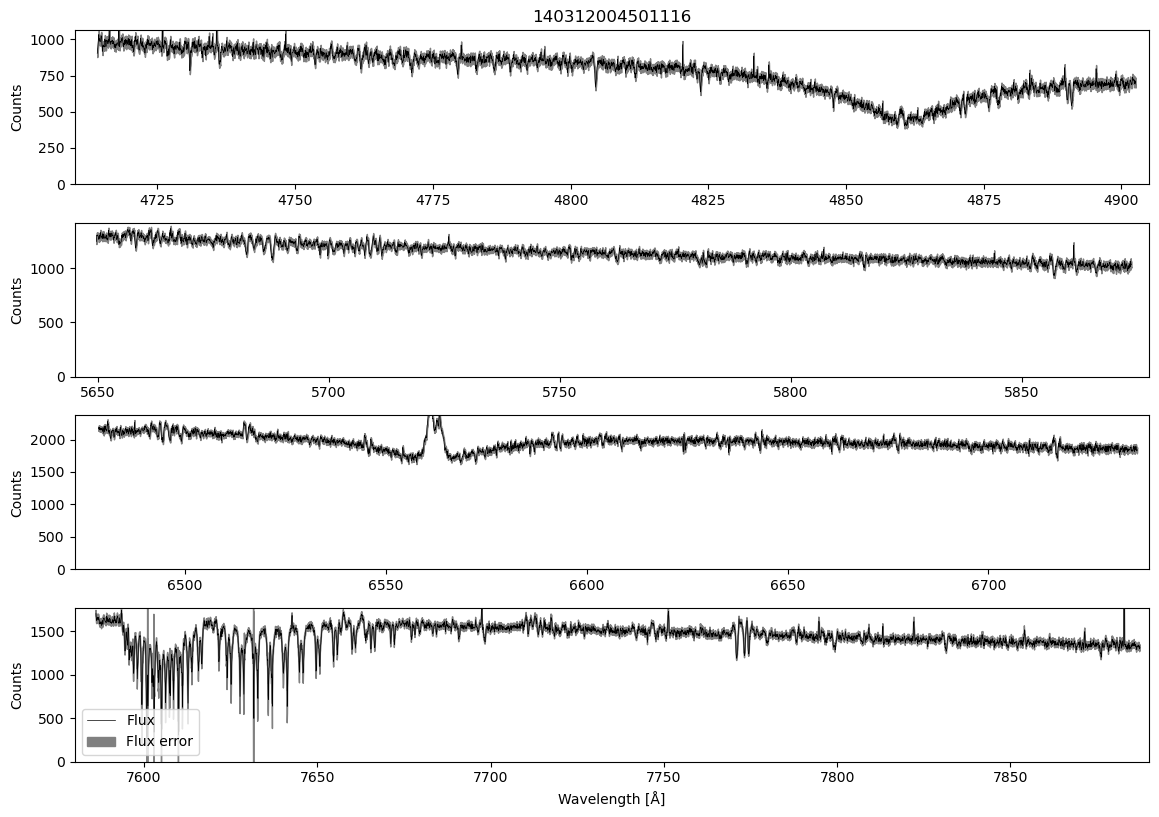

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [88]:
for sobject_id in sobject_ids:
    spectrum = read_spectra(sobject_id)
    f = plot_spectra(sobject_id, normalised=False)